экспериментальные структуры и свойства
Исходные данные (первые 5 строк):
    Alkane_Name  SMILES  Refractive_Index_Exp
0        Ethane      CC                1.3550
1       Propane     CCC                1.3400
2   Butane (n-)    CCCC                1.3326
3     Isobutane  CC(C)C                1.3518
4  Pentane (n-)   CCCCC                1.3580
Всего молекул в наборе данных: 16
Генерация молекулярных дескрипторов из SMILES

Данные с сгенерированными дескрипторами (первые 5 строк):
    Alkane_Name  SMILES  Refractive_Index_Exp   MolWt  HeavyAtomCount  \
0        Ethane      CC                1.3550  30.070               2   
1       Propane     CCC                1.3400  44.097               3   
2   Butane (n-)    CCCC                1.3326  58.124               4   
3     Isobutane  CC(C)C                1.3518  58.124               4   
4  Pentane (n-)   CCCCC                1.3580  72.151               5   

   NumRotatableBonds  BalabanJ  Kappa1    Kappa2  Kappa3  ...  HallKierAl

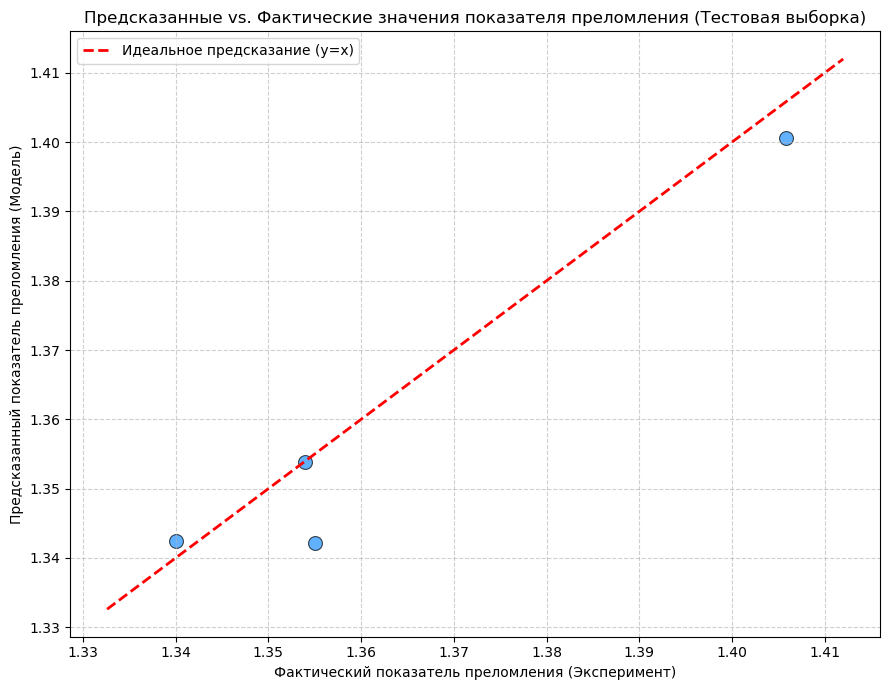

анализ важности дескрипторов

топ-5 наиболее влиятельных дескрипторов:
                Feature  Importance
0                 MolWt    0.139160
7                   Ipc    0.114024
10  NumValenceElectrons    0.113759
1        HeavyAtomCount    0.100547
9                 MolMR    0.098169


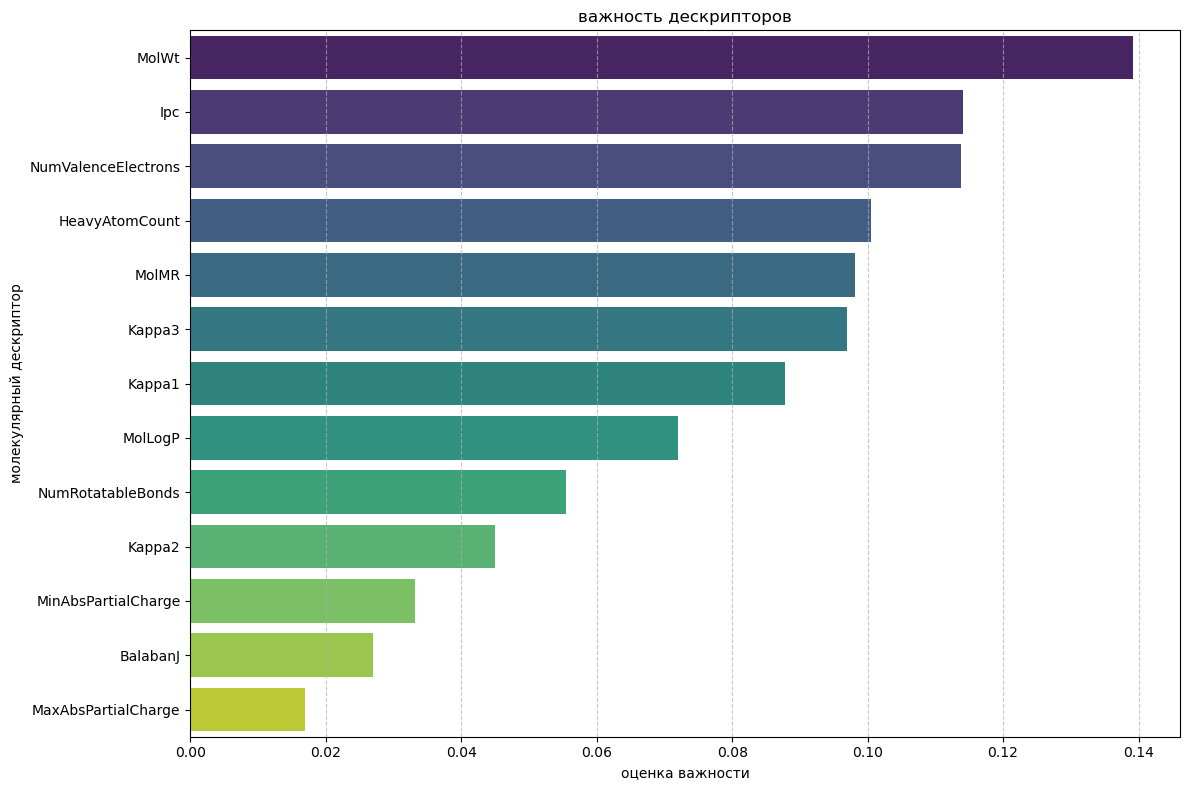

предсказание показателя преломления для новой молекулы

Предсказание для 'n-Dodecane (Hypothetical)' (SMILES: 'CCCCCCCCCCCC'):
  Предсказанный показатель преломления: 1.4035


In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data collection
print("экспериментальные структуры и свойства")
data = {
    'Alkane_Name': [
        'Ethane', 'Propane', 'Butane (n-)', 'Isobutane',
        'Pentane (n-)', 'Isopentane', 'Neopentane', 'Hexane (n-)', '2-Methylpentane',
        '3-Methylpentane', '2,2-Dimethylbutane', '2,3-Dimethylbutane',
        'Heptane (n-)', 'Octane (n-)', 'Nonane (n-)', 'Decane (n-)'
    ],
    'SMILES': [
        'CC', 'CCC', 'CCCC', 'CC(C)C',
        'CCCCC', 'CCC(C)C', 'CC(C)(C)C', 'CCCCCC', 'CCCC(C)C',
        'CCC(C)CC', 'CC(C)(C)CC', 'CC(C)C(C)C',
        'CCCCCCC', 'CCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCCC'
    ],
    'Refractive_Index_Exp': [
        1.355,	1.34, 1.3326, 1.3518,
        	1.358, 1.354, 1.3476, 1.375, 1.371,
        1.376, 1.369 ,  1.375,
        1.3855, 1.397, 	1.4058, 	1.412
    ]
}
df = pd.DataFrame(data)

print("Исходные данные (первые 5 строк):")
print(df.head())
print(f"Всего молекул в наборе данных: {len(df)}")

# Descriptors
print("Генерация молекулярных дескрипторов из SMILES")

df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

if df['Mol'].isnull().any():
    print("Некоторые SMILES не были корректно преобразованы в объекты Mol. Проверьте исходные SMILES")
    df = df.dropna(subset=['Mol'])
    print(f"После очистки осталось молекул: {len(df)}")

selected_descriptor_funcs = [
    Descriptors.MolWt,
    Descriptors.HeavyAtomCount,
    Descriptors.NumRotatableBonds,
    Descriptors.BalabanJ,
    Descriptors.Kappa1,
    Descriptors.Kappa2,
    Descriptors.Kappa3,
    Descriptors.FractionCSP3,
    Descriptors.HallKierAlpha,
    Descriptors.Ipc,
    Descriptors.PEOE_VSA1,
    Descriptors.PEOE_VSA2,
    Descriptors.PEOE_VSA3,
    Descriptors.MolLogP,
    Descriptors.MolMR,
    Descriptors.NumValenceElectrons,
    Descriptors.MaxAbsPartialCharge,
    Descriptors.MinAbsPartialCharge,
]

descriptor_names = [
    'MolWt', 'HeavyAtomCount', 'NumRotatableBonds', 'BalabanJ',
    'Kappa1', 'Kappa2', 'Kappa3', 'FractionCSP3', 'HallKierAlpha', 'Ipc',
    'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'MolLogP', 'MolMR',
    'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge'
]

descriptor_list = []

for mol in df['Mol']:
    try:
        AllChem.ComputeGasteigerCharges(mol)
        desc_values = [func(mol) for func in selected_descriptor_funcs]
        descriptor_list.append(desc_values)
    except Exception as e:
        print(f"Ошибка при генерации дескрипторов для молекулы: {Chem.MolToSmiles(mol) if mol else 'Неизвестная'} - {e}")
        descriptor_list.append([np.nan] * len(selected_descriptor_funcs))

desc_df = pd.DataFrame(descriptor_list, columns=descriptor_names)
df_final = pd.concat([df.drop('Mol', axis=1), desc_df], axis=1)

print("\nДанные с сгенерированными дескрипторами (первые 5 строк):")
print(df_final.head())

# Machine Learning
X = df_final[descriptor_names]
y = df_final['Refractive_Index_Exp']

initial_num_features = X.shape[1]
X = X.loc[:, (X != X.iloc[0]).any()]
X = X.dropna(axis=1)
cleaned_num_features = X.shape[1]

if initial_num_features > cleaned_num_features:
    print(f"Удалено {initial_num_features - cleaned_num_features} константных или NaN-дескрипторов.")
    print(f"Осталось дескрипторов для моделирования: {cleaned_num_features}")

if X.empty:
    raise ValueError("После очистки не осталось дескрипторов")

print(f"\nДескрипторы для моделирования:")
print(X.head())
print(f"\nЦелевая переменная:")
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

# Modeling
print("обучение модели RFR")

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("модель RFR обучена")

# Assesment
print("оценка модели")

y_pred_test = model.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print(f"  Метрики на тестовой выборке:")
print(f"  R^2 (коэффициент детерминации): {r2:.3f}")
print(f"  RMSE (среднеквадратичная ошибка): {rmse:.5f}")
print(f"  MAE (средняя абсолютная ошибка): {mae:.5f}")

plt.figure(figsize=(9, 7))
sns.scatterplot(x=y_test, y=y_pred_test, s=100, alpha=0.7, color='dodgerblue', edgecolor='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Идеальное предсказание (y=x)')
plt.xlabel('Фактический показатель преломления (Эксперимент)')
plt.ylabel('Предсказанный показатель преломления (Модель)')
plt.title('Предсказанные vs. Фактические значения показателя преломления (Тестовая выборка)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Analysis
print("анализ важности дескрипторов")

if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nтоп-5 наиболее влиятельных дескрипторов:")
    print(importance_df.head(5))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', legend=False)
    plt.title('важность дескрипторов')
    plt.xlabel('оценка важности')
    plt.ylabel('молекулярный дескриптор')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("модель не поддерживает прямую оценку важности признаков.")
    
# Application
print("предсказание показателя преломления для новой молекулы")

new_alkane_smiles = 'CCCCCCCCCCCC'
new_alkane_name = 'n-Dodecane (Hypothetical)'

new_mol = Chem.MolFromSmiles(new_alkane_smiles)

if new_mol is None:
    print(f"Ошибка: Некорректный SMILES для '{new_alkane_name}'. Невозможно предсказать.")
else:
    try:
        AllChem.ComputeGasteigerCharges(new_mol)
        new_desc_values = [func(new_mol) for func in selected_descriptor_funcs]
        new_desc_df = pd.DataFrame([new_desc_values], columns=descriptor_names)

        new_X_for_prediction = new_desc_df[X.columns]

        predicted_ri = model.predict(new_X_for_prediction)[0]

        print(f"\nПредсказание для '{new_alkane_name}' (SMILES: '{new_alkane_smiles}'):")
        print(f"  Предсказанный показатель преломления: {predicted_ri:.4f}")
        
    except Exception as e:
        print(f"Ошибка при предсказании для новой молекулы '{new_alkane_name}': {e}")